Début ZFE Grenoble : 2019-05-02
Stations présentes :      station_id         station_name
0       FR15043  Grenoble Les Frenes
2919    FR15046  Grenoble Boulevards
Aperçu monthly :


,station_id,station_name,date,no2_ug_m3
0,FR15043,Grenoble Les Frenes,2016-02-01,24.080000
1,FR15043,Grenoble Les Frenes,2016-03-01,21.774194
2,FR15043,Grenoble Les Frenes,2016-04-01,15.356667
3,FR15043,Grenoble Les Frenes,2016-05-01,12.516129
4,FR15043,Grenoble Les Frenes,2016-06-01,13.043333


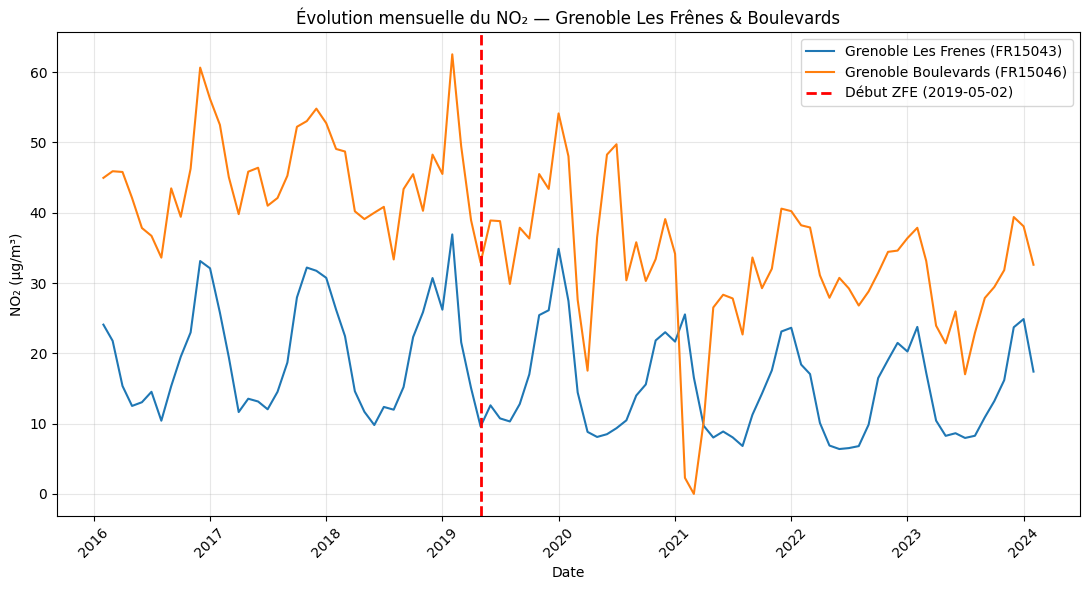

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ---------- chemins ----------
HERE = Path().resolve()      # zfe-scm/
ROOT = HERE.parent           # racine du projet
DATA = ROOT / "data"

# ---------- 1) date de début de la ZFE Grenoble ----------
meta = pd.read_csv(DATA / "zfe_meta.csv")
grenoble_row = meta.loc[meta["publisher_zfe_id"] == "GRENOBLE"].iloc[0]
zfe_start = pd.to_datetime(grenoble_row["first_date_debut"])
print("Début ZFE Grenoble :", zfe_start.date())

# ---------- 2) NO2 daily propre pour les deux stations ----------
no2 = pd.read_csv(DATA / "pollution_grenoble_no2_daily_clean.csv")
no2["date"] = pd.to_datetime(no2["date"])

print("Stations présentes :", no2[["station_id", "station_name"]].drop_duplicates())

# ---------- 3) agrégation mensuelle par station ----------
no2 = no2.set_index("date")

monthly = (
    no2
    .groupby(["station_id", "station_name"])["no2_ug_m3"]
    .resample("MS")   # MS = début de mois
    .mean()
    .reset_index()
)

print("Aperçu monthly :")
display(monthly.head())

# ---------- 4) tracé pour Les Frênes + Boulevards ----------
plt.figure(figsize=(11, 6))

for (sid, name), sub in monthly.groupby(["station_id", "station_name"]):
    plt.plot(sub["date"], sub["no2_ug_m3"], label=f"{name} ({sid})")

# trait vertical rouge = début ZFE
plt.axvline(
    zfe_start,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Début ZFE ({zfe_start.date()})",
)

plt.title("Évolution mensuelle du NO₂ — Grenoble Les Frênes & Boulevards")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Début ZFE Grenoble : 2019-05-02
Stations Grenoble :


,station_id,station_name
0,FR15043,Grenoble Les Frenes
2919,FR15046,Grenoble Boulevards


Stations donneuses (no2_all_stations_daily_clean) :


,station_id,station_name
0,FR15018,Voiron Urbain
2907,FR15045,Grenoble PeriurbSud
5827,FR15048,Gresivaudan Periurb
8748,FR24038,GAP JEAN JAURES
11669,FR27007,Bourgoin-Jallieu


Station traitée : Grenoble Les Frenes (FR15043)
Période du panel : 2016-02-01 → 2023-12-01
Nombre de donneurs utilisés : 10
Ridge – alpha* = 754.3120
Lasso – alpha* = 2.2230
ElasticNet – alpha* = 2.4245, l1_ratio* = 0.90
RMSE pré-ZFE (ridge) : 2.293
RMSE pré-ZFE (lasso) : 2.142
RMSE pré-ZFE (elasticnet) : 2.144


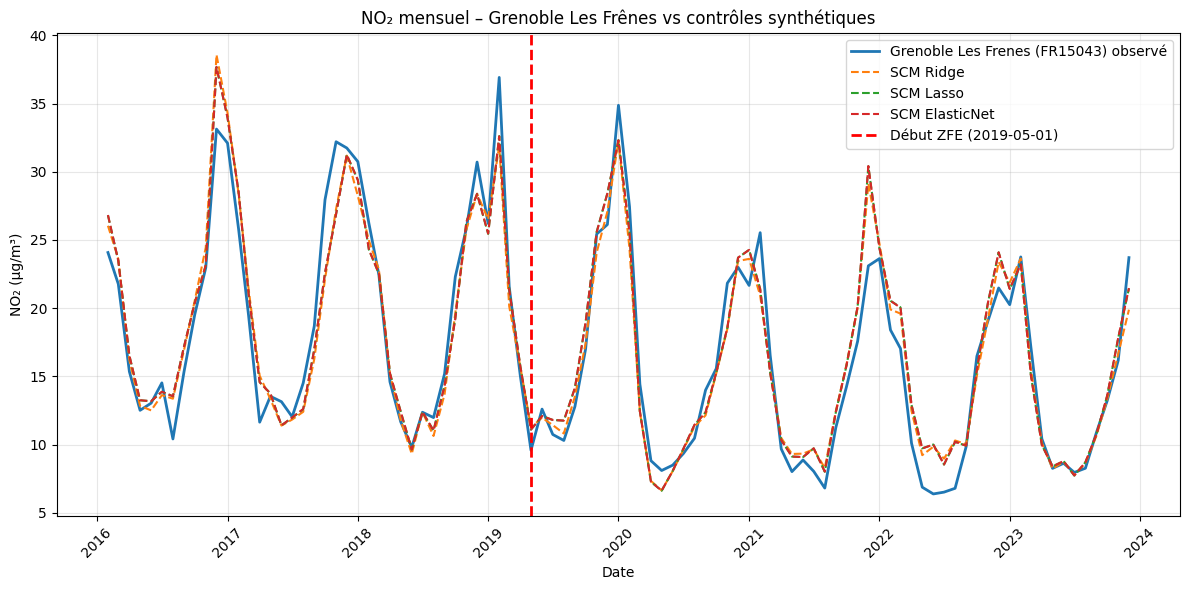

<Figure size 1200x600 with 0 Axes>

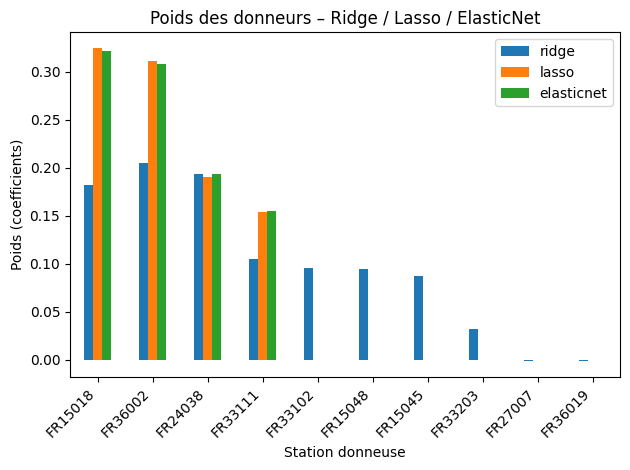

,ridge,lasso,elasticnet
station_id,,,
FR15018,0.181721,0.324701,0.321624
FR36002,0.205291,0.311188,0.308502
FR24038,0.193889,0.190706,0.193963
FR33111,0.104950,0.153734,0.154867
FR33102,0.095334,0.000000,0.000000
FR15048,0.094769,0.000000,0.000000
FR15045,0.087629,0.000000,0.000000
FR33203,0.031552,-0.000000,-0.000000
FR27007,-0.001828,-0.000000,-0.000000


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error

# =============================
# 0. Chemins & chargement
# =============================
HERE = Path().resolve()      # dossier zfe-scm
ROOT = HERE.parent           # racine du projet
DATA = ROOT / "data"

# Grenoble (Les Frênes + Boulevards)
grenoble_daily = pd.read_csv(DATA / "pollution_grenoble_no2_daily_clean.csv")
grenoble_daily["date"] = pd.to_datetime(grenoble_daily["date"])

# Donneurs (autres stations, hors Grenoble)
donors_daily = pd.read_csv(DATA / "no2_all_stations_daily_clean.csv")
donors_daily["date"] = pd.to_datetime(donors_daily["date"])


# Meta ZFE pour la date de traitement
zfe_meta = pd.read_csv(DATA / "zfe_meta.csv")
grenoble_row = zfe_meta.loc[zfe_meta["publisher_zfe_id"] == "GRENOBLE"].iloc[0]
zfe_start = pd.to_datetime(grenoble_row["first_date_debut"])
zfe_start_month = zfe_start.to_period("M").to_timestamp()
print("Début ZFE Grenoble :", zfe_start.date())

# Harmoniser les IDs
grenoble_daily["station_id"] = grenoble_daily["station_id"].astype(str).str.strip()
donors_daily["station_id"]   = donors_daily["station_id"].astype(str).str.strip()

print("Stations Grenoble :")
display(grenoble_daily[["station_id", "station_name"]].drop_duplicates())

print("Stations donneuses (no2_all_stations_daily_clean) :")
display(donors_daily[["station_id", "station_name"]].drop_duplicates().head())

# =============================
# 1. Station traitée = Les Frênes
# =============================

treated_gdf = grenoble_daily[
    grenoble_daily["station_name"].str.contains("frene", case=False, na=False)
].copy()

if treated_gdf.empty:
    raise ValueError("Impossible de trouver la station 'Les Frênes' dans pollution_grenoble_no2_daily_clean.csv")

treated_id = treated_gdf["station_id"].iloc[0]
treated_name = treated_gdf["station_name"].iloc[0]

print(f"Station traitée : {treated_name} ({treated_id})")

# Série mensuelle traitée
treated_monthly = (
    treated_gdf
    .set_index("date")["no2_ug_m3"]
    .resample("MS")
    .mean()
)

# Restreindre la fenêtre de temps (ajuste si besoin)
start = pd.to_datetime("2016-02-01")
end   = pd.to_datetime("2023-12-01")
treated_monthly = treated_monthly.loc[(treated_monthly.index >= start) & (treated_monthly.index <= end)]

# =============================
# 2. Panel mensuel des donneurs
# =============================

donors_monthly = (
    donors_daily
    .set_index("date")
    .groupby("station_id")["no2_ug_m3"]
    .resample("MS")
    .mean()
    .reset_index()
)

donors_wide = (
    donors_monthly
    .pivot(index="date", columns="station_id", values="no2_ug_m3")
    .sort_index()
)

# Aligner les dates sur celles de la station traitée
panel = donors_wide.copy()
panel["treated"] = treated_monthly
panel = panel.dropna(subset=["treated"])  # on garde seulement les mois où on a la station traitée

# Restriction de période déjà appliquée à treated_monthly
panel = panel.loc[(panel.index >= start) & (panel.index <= end)]

# Matrice donneurs + série traitée
donor_matrix = panel.drop(columns=["treated"]).copy()

# Interpolation temporelle pour les trous
donor_matrix = donor_matrix.interpolate(limit_direction="both")

# Supprimer les donneurs complètement vides (au cas où)
donor_matrix = donor_matrix.dropna(axis=1, how="all")

donor_ids = donor_matrix.columns.tolist()
treated_series = panel["treated"]

print("Période du panel :", treated_series.index.min().date(), "→", treated_series.index.max().date())
print("Nombre de donneurs utilisés :", len(donor_ids))

# Masques pré / post ZFE
pre_mask = treated_series.index < zfe_start_month
post_mask = treated_series.index >= zfe_start_month

X_pre = donor_matrix.loc[pre_mask]
y_pre = treated_series.loc[pre_mask]
X_all = donor_matrix

# =============================
# 3. Fonctions SCM (Ridge / Lasso / ElasticNet)
# =============================

def fit_ridge(X_pre, y_pre, X_all):
    alphas = np.logspace(-3, 3, 50)
    model = RidgeCV(alphas=alphas, cv=5, fit_intercept=False)
    model.fit(X_pre, y_pre)
    y_hat = pd.Series(model.predict(X_all), index=X_all.index, name="ridge")
    weights = pd.Series(model.coef_, index=X_pre.columns, name="ridge")
    return y_hat, weights, model.alpha_

def fit_lasso(X_pre, y_pre, X_all):
    alphas = np.logspace(-3, 1, 50)
    model = LassoCV(alphas=alphas, cv=5, fit_intercept=False, max_iter=10000)
    model.fit(X_pre, y_pre)
    y_hat = pd.Series(model.predict(X_all), index=X_all.index, name="lasso")
    weights = pd.Series(model.coef_, index=X_pre.columns, name="lasso")
    return y_hat, weights, model.alpha_

def fit_elasticnet(X_pre, y_pre, X_all):
    alphas = np.logspace(-3, 1, 40)
    l1s = [0.1, 0.5, 0.9]
    model = ElasticNetCV(
        alphas=alphas,
        l1_ratio=l1s,
        cv=5,
        fit_intercept=False,
        max_iter=10000,
    )
    model.fit(X_pre, y_pre)
    y_hat = pd.Series(model.predict(X_all), index=X_all.index, name="elasticnet")
    weights = pd.Series(model.coef_, index=X_pre.columns, name="elasticnet")
    return y_hat, weights, (model.alpha_, model.l1_ratio_)

# =============================
# 4. Ajustements Ridge / Lasso / ElasticNet
# =============================

y_ridge, w_ridge, alpha_ridge = fit_ridge(X_pre, y_pre, X_all)
y_lasso, w_lasso, alpha_lasso = fit_lasso(X_pre, y_pre, X_all)
y_en, w_en, (alpha_en, l1_en) = fit_elasticnet(X_pre, y_pre, X_all)

print(f"Ridge – alpha* = {alpha_ridge:.4f}")
print(f"Lasso – alpha* = {alpha_lasso:.4f}")
print(f"ElasticNet – alpha* = {alpha_en:.4f}, l1_ratio* = {l1_en:.2f}")

# RMSE pré-traitement pour diagnostique
for name, y_syn in [("ridge", y_ridge), ("lasso", y_lasso), ("elasticnet", y_en)]:
    mse_pre = mean_squared_error(
        treated_series[pre_mask],
        y_syn[pre_mask],
    )
    rmse_pre = mse_pre ** 0.5
    print(f"RMSE pré-ZFE ({name}) : {rmse_pre:.3f}")


# =============================
# 5. Graphique série temporelle
# =============================

plt.figure(figsize=(12, 6))

plt.plot(treated_series.index, treated_series.values,
         label=f"{treated_name} ({treated_id}) observé", linewidth=2)

plt.plot(y_ridge.index, y_ridge.values, label="SCM Ridge", linestyle="--")
plt.plot(y_lasso.index, y_lasso.values, label="SCM Lasso", linestyle="--")
plt.plot(y_en.index, y_en.values, label="SCM ElasticNet", linestyle="--")

plt.axvline(zfe_start_month, color="red", linestyle="--", linewidth=2,
            label=f"Début ZFE ({zfe_start_month.date()})")

plt.title("NO₂ mensuel – Grenoble Les Frênes vs contrôles synthétiques")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================
# 6. Graphique des poids par donneur
# =============================

weights_df = pd.concat([w_ridge, w_lasso, w_en], axis=1).fillna(0.0)
weights_df.index.name = "station_id"

# Tri par importance moyenne
weights_df["mean_abs"] = weights_df.abs().mean(axis=1)
weights_df = weights_df.sort_values("mean_abs", ascending=False)
weights_df = weights_df.drop(columns=["mean_abs"])

plt.figure(figsize=(12, 6))
weights_df.plot(kind="bar")
plt.title("Poids des donneurs – Ridge / Lasso / ElasticNet")
plt.xlabel("Station donneuse")
plt.ylabel("Poids (coefficients)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

weights_df


Début ZFE Grenoble : 2019-05-02
Stations Grenoble :


,station_id,station_name
0,FR15043,Grenoble Les Frenes
2919,FR15046,Grenoble Boulevards


Station traitée : Grenoble Boulevards (FR15046)
Période du panel : 2016-02-01 → 2023-12-01
Nombre de donneurs utilisés : 10
Ridge – alpha* = 323.7458
Lasso – alpha* = 1.5264
ElasticNet – alpha* = 2.4245, l1_ratio* = 0.50
RMSE pré-ZFE (ridge) : 5.878
RMSE pré-ZFE (lasso) : 5.383
RMSE pré-ZFE (elasticnet) : 5.437


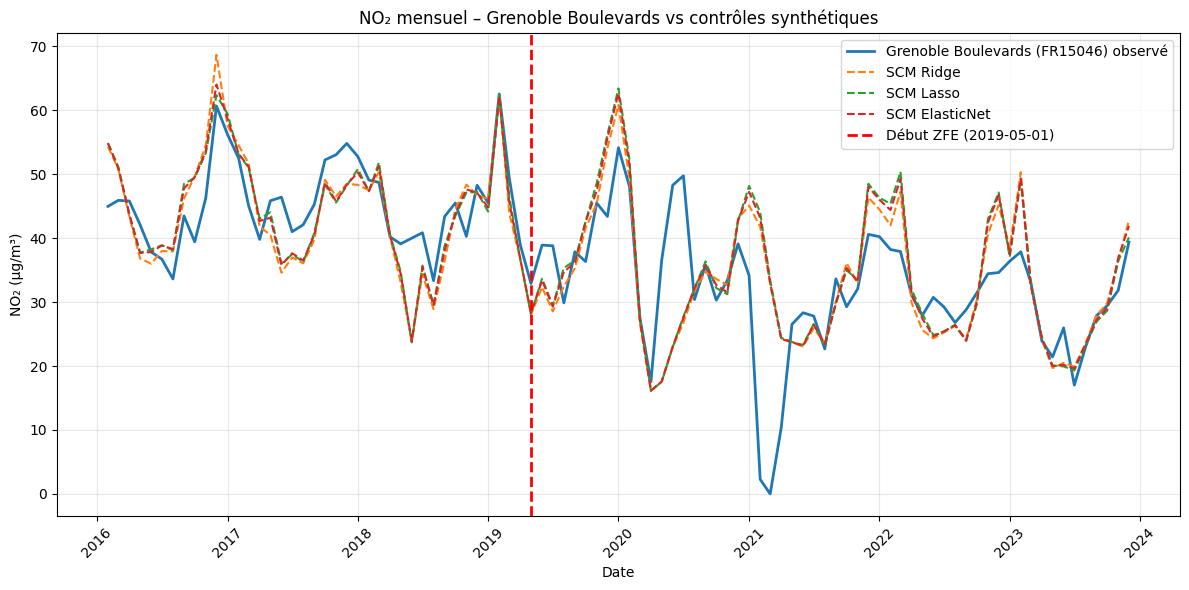

<Figure size 1200x600 with 0 Axes>

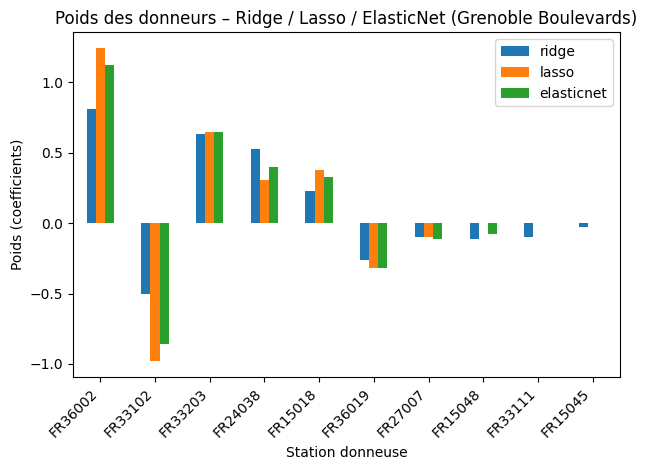

,ridge,lasso,elasticnet
station_id,,,
FR36002,0.812649,1.243662,1.122824
FR33102,-0.502750,-0.982501,-0.858018
FR33203,0.634850,0.645857,0.645993
FR24038,0.528387,0.309092,0.401899
FR15018,0.228396,0.380224,0.330840
FR36019,-0.261943,-0.317394,-0.316396
FR27007,-0.097704,-0.101117,-0.113263
FR15048,-0.111177,-0.000000,-0.079986
FR33111,-0.100412,0.000000,0.000000


In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error

# =============================
# 0. Chemins & chargement
# =============================
HERE = Path().resolve()      # dossier zfe-scm
ROOT = HERE.parent           # racine du projet
DATA = ROOT / "data"

# Grenoble (Les Frênes + Boulevards)
grenoble_daily = pd.read_csv(DATA / "pollution_grenoble_no2_daily_clean.csv")
grenoble_daily["date"] = pd.to_datetime(grenoble_daily["date"])

# Donneurs (autres stations, hors Grenoble)
donors_daily = pd.read_csv(DATA / "no2_all_stations_daily_clean.csv")
donors_daily["date"] = pd.to_datetime(donors_daily["date"])



# Meta ZFE pour la date de traitement
zfe_meta = pd.read_csv(DATA / "zfe_meta.csv")
grenoble_row = zfe_meta.loc[zfe_meta["publisher_zfe_id"] == "GRENOBLE"].iloc[0]
zfe_start = pd.to_datetime(grenoble_row["first_date_debut"])
zfe_start_month = zfe_start.to_period("M").to_timestamp()
print("Début ZFE Grenoble :", zfe_start.date())

# Harmoniser les IDs
grenoble_daily["station_id"] = grenoble_daily["station_id"].astype(str).str.strip()
donors_daily["station_id"]   = donors_daily["station_id"].astype(str).str.strip()

print("Stations Grenoble :")
display(grenoble_daily[["station_id", "station_name"]].drop_duplicates())

# =============================
# 1. Station traitée = Grenoble Boulevards
# =============================

treated_gdf = grenoble_daily[
    grenoble_daily["station_name"].str.contains("boulevard", case=False, na=False)
].copy()

if treated_gdf.empty:
    # fallback si jamais le nom ne matche pas, on force FR15046
    treated_gdf = grenoble_daily[grenoble_daily["station_id"] == "FR15046"].copy()

if treated_gdf.empty:
    raise ValueError("Impossible de trouver la station 'Grenoble Boulevards' dans pollution_grenoble_no2_daily_clean.csv")

treated_id = treated_gdf["station_id"].iloc[0]
treated_name = treated_gdf["station_name"].iloc[0]

print(f"Station traitée : {treated_name} ({treated_id})")

# Série mensuelle traitée
treated_monthly = (
    treated_gdf
    .set_index("date")["no2_ug_m3"]
    .resample("MS")
    .mean()
)

# Restreindre la fenêtre de temps (ajuste si besoin)
start = pd.to_datetime("2016-02-01")
end   = pd.to_datetime("2023-12-01")
treated_monthly = treated_monthly.loc[(treated_monthly.index >= start) & (treated_monthly.index <= end)]

# =============================
# 2. Panel mensuel des donneurs
# =============================

donors_monthly = (
    donors_daily
    .set_index("date")
    .groupby("station_id")["no2_ug_m3"]
    .resample("MS")
    .mean()
    .reset_index()
)

donors_wide = (
    donors_monthly
    .pivot(index="date", columns="station_id", values="no2_ug_m3")
    .sort_index()
)

# Aligner les dates sur celles de la station traitée
panel = donors_wide.copy()
panel["treated"] = treated_monthly
panel = panel.dropna(subset=["treated"])

panel = panel.loc[(panel.index >= start) & (panel.index <= end)]

donor_matrix = panel.drop(columns=["treated"]).copy()
donor_matrix = donor_matrix.interpolate(limit_direction="both")
donor_matrix = donor_matrix.dropna(axis=1, how="all")

donor_ids = donor_matrix.columns.tolist()
treated_series = panel["treated"]

print("Période du panel :", treated_series.index.min().date(), "→", treated_series.index.max().date())
print("Nombre de donneurs utilisés :", len(donor_ids))

# Masques pré / post ZFE
pre_mask = treated_series.index < zfe_start_month
post_mask = treated_series.index >= zfe_start_month

X_pre = donor_matrix.loc[pre_mask]
y_pre = treated_series.loc[pre_mask]
X_all = donor_matrix

# =============================
# 3. Fonctions SCM (Ridge / Lasso / ElasticNet)
# =============================

def fit_ridge(X_pre, y_pre, X_all):
    alphas = np.logspace(-3, 3, 50)
    model = RidgeCV(alphas=alphas, cv=5, fit_intercept=False)
    model.fit(X_pre, y_pre)
    y_hat = pd.Series(model.predict(X_all), index=X_all.index, name="ridge")
    weights = pd.Series(model.coef_, index=X_pre.columns, name="ridge")
    return y_hat, weights, model.alpha_

def fit_lasso(X_pre, y_pre, X_all):
    alphas = np.logspace(-3, 1, 50)
    model = LassoCV(alphas=alphas, cv=5, fit_intercept=False, max_iter=10000)
    model.fit(X_pre, y_pre)
    y_hat = pd.Series(model.predict(X_all), index=X_all.index, name="lasso")
    weights = pd.Series(model.coef_, index=X_pre.columns, name="lasso")
    return y_hat, weights, model.alpha_

def fit_elasticnet(X_pre, y_pre, X_all):
    alphas = np.logspace(-3, 1, 40)
    l1s = [0.1, 0.5, 0.9]
    model = ElasticNetCV(
        alphas=alphas,
        l1_ratio=l1s,
        cv=5,
        fit_intercept=False,
        max_iter=10000,
    )
    model.fit(X_pre, y_pre)
    y_hat = pd.Series(model.predict(X_all), index=X_all.index, name="elasticnet")
    weights = pd.Series(model.coef_, index=X_pre.columns, name="elasticnet")
    return y_hat, weights, (model.alpha_, model.l1_ratio_)

# =============================
# 4. Ajustements Ridge / Lasso / ElasticNet
# =============================

y_ridge, w_ridge, alpha_ridge = fit_ridge(X_pre, y_pre, X_all)
y_lasso, w_lasso, alpha_lasso = fit_lasso(X_pre, y_pre, X_all)
y_en, w_en, (alpha_en, l1_en) = fit_elasticnet(X_pre, y_pre, X_all)

print(f"Ridge – alpha* = {alpha_ridge:.4f}")
print(f"Lasso – alpha* = {alpha_lasso:.4f}")
print(f"ElasticNet – alpha* = {alpha_en:.4f}, l1_ratio* = {l1_en:.2f}")

# RMSE pré-traitement
for name, y_syn in [("ridge", y_ridge), ("lasso", y_lasso), ("elasticnet", y_en)]:
    mse_pre = mean_squared_error(
        treated_series[pre_mask],
        y_syn[pre_mask],
    )
    rmse_pre = mse_pre ** 0.5
    print(f"RMSE pré-ZFE ({name}) : {rmse_pre:.3f}")

# =============================
# 5. Graphique série temporelle
# =============================

plt.figure(figsize=(12, 6))

plt.plot(treated_series.index, treated_series.values,
         label=f"{treated_name} ({treated_id}) observé", linewidth=2)

plt.plot(y_ridge.index, y_ridge.values, label="SCM Ridge", linestyle="--")
plt.plot(y_lasso.index, y_lasso.values, label="SCM Lasso", linestyle="--")
plt.plot(y_en.index, y_en.values, label="SCM ElasticNet", linestyle="--")

plt.axvline(zfe_start_month, color="red", linestyle="--", linewidth=2,
            label=f"Début ZFE ({zfe_start_month.date()})")

plt.title("NO₂ mensuel – Grenoble Boulevards vs contrôles synthétiques")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================
# 6. Graphique des poids par donneur
# =============================

weights_df = pd.concat([w_ridge, w_lasso, w_en], axis=1).fillna(0.0)
weights_df.index.name = "station_id"

weights_df["mean_abs"] = weights_df.abs().mean(axis=1)
weights_df = weights_df.sort_values("mean_abs", ascending=False)
weights_df = weights_df.drop(columns=["mean_abs"])

plt.figure(figsize=(12, 6))
weights_df.plot(kind="bar")
plt.title("Poids des donneurs – Ridge / Lasso / ElasticNet (Grenoble Boulevards)")
plt.xlabel("Station donneuse")
plt.ylabel("Poids (coefficients)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

weights_df


Début ZFE Grenoble : 2019-05-02
Stations Grenoble :


,station_id,station_name
0,FR15043,Grenoble Les Frenes
2919,FR15046,Grenoble Boulevards


Station traitée (ML) : Grenoble Les Frenes (FR15043)
Shape X : (95, 13)  | nb donneurs : 10
RMSE CV pré-ZFE (RF) : 3.876
RMSE CV pré-ZFE (GB) : 3.682


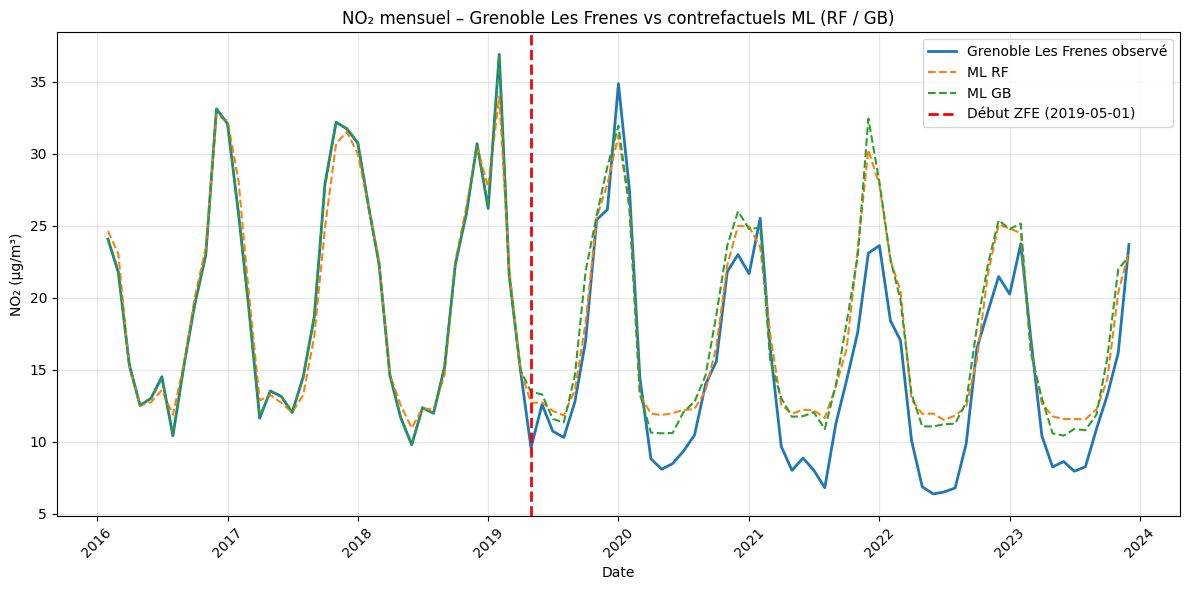

RF – RMSE pré-ZFE : 1.056 | RMSE post-ZFE : 3.157
GB – RMSE pré-ZFE : 0.076 | RMSE post-ZFE : 3.270


In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# =============================
# 0. Chemins & chargement
# =============================
HERE = Path().resolve()      # dossier zfe-scm
ROOT = HERE.parent           # racine du projet
DATA = ROOT / "data"

# Grenoble (Les Frênes + Boulevards)
grenoble_daily = pd.read_csv(DATA / "pollution_grenoble_no2_daily_clean.csv")
grenoble_daily["date"] = pd.to_datetime(grenoble_daily["date"])

# Donneurs
donors_daily = pd.read_csv(DATA / "no2_all_stations_daily_clean.csv")
donors_daily["date"] = pd.to_datetime(donors_daily["date"])

# Meta ZFE pour la date de traitement
zfe_meta = pd.read_csv(DATA / "zfe_meta.csv")
grenoble_row = zfe_meta.loc[zfe_meta["publisher_zfe_id"] == "GRENOBLE"].iloc[0]
zfe_start = pd.to_datetime(grenoble_row["first_date_debut"])
zfe_start_month = zfe_start.to_period("M").to_timestamp()
print("Début ZFE Grenoble :", zfe_start.date())

# Harmoniser les IDs
grenoble_daily["station_id"] = grenoble_daily["station_id"].astype(str).str.strip()
donors_daily["station_id"]   = donors_daily["station_id"].astype(str).str.strip()

print("Stations Grenoble :")
display(grenoble_daily[["station_id", "station_name"]].drop_duplicates())

# =============================
# 1. Station traitée = Les Frênes
#    (change 'frene' en 'boulevard' pour l'autre station)
# =============================
treated_pattern = "frene"  

treated_gdf = grenoble_daily[
    grenoble_daily["station_name"].str.contains(treated_pattern, case=False, na=False)
].copy()

if treated_gdf.empty:
    raise ValueError("Impossible de trouver la station traitée avec ce pattern de nom.")

treated_id = treated_gdf["station_id"].iloc[0]
treated_name = treated_gdf["station_name"].iloc[0]
print(f"Station traitée (ML) : {treated_name} ({treated_id})")

# NO2 mensuel station traitée
treated_monthly = (
    treated_gdf
    .set_index("date")["no2_ug_m3"]
    .resample("MS")
    .mean()
)

# =============================
# 2. Panel donneurs mensuel
# =============================
donors_monthly = (
    donors_daily
    .set_index("date")
    .groupby("station_id")["no2_ug_m3"]
    .resample("MS")
    .mean()
    .reset_index()
)

donors_wide = (
    donors_monthly
    .pivot(index="date", columns="station_id", values="no2_ug_m3")
    .sort_index()
)

# =============================
# 3. Construction X / y pour ML
# =============================
# Aligner les dates
panel = donors_wide.copy()
panel["y"] = treated_monthly
panel = panel.dropna(subset=["y"])

# Restreindre la période
start = pd.to_datetime("2016-02-01")
end   = pd.to_datetime("2023-12-01")
panel = panel.loc[(panel.index >= start) & (panel.index <= end)]

# Features de base = NO2 des donneurs
X = panel.drop(columns=["y"]).copy()
# Interpolation des trous côté donneurs
X = X.interpolate(limit_direction="both")
X = X.dropna(axis=1, how="all")  # enlever donneurs complètement vides
donor_ids = X.columns.tolist()

# Ajouter des features de saisonnalité / tendance
dates = panel.index
month = dates.month
t = np.arange(len(dates))  # tendance linéaire

X["month_sin"] = np.sin(2 * np.pi * month / 12)
X["month_cos"] = np.cos(2 * np.pi * month / 12)
X["trend"] = t

y = panel["y"]

print("Shape X :", X.shape, " | nb donneurs :", len(donor_ids))

# Masques pré / post ZFE
pre_mask = dates < zfe_start_month
post_mask = dates >= zfe_start_month

X_pre, y_pre = X[pre_mask], y[pre_mask]
X_all = X

# =============================
# 4. Validation croisée temporelle sur le pré-ZFE
# =============================
tscv = TimeSeriesSplit(n_splits=5)

def eval_model(model, X_pre, y_pre):
    rmses = []
    for train_idx, test_idx in tscv.split(X_pre):
        X_tr, X_te = X_pre.iloc[train_idx], X_pre.iloc[test_idx]
        y_tr, y_te = y_pre.iloc[train_idx], y_pre.iloc[test_idx]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        mse = mean_squared_error(y_te, y_pred)
        rmses.append(mse ** 0.5)
    return np.mean(rmses)

models = {
    "RF": RandomForestRegressor(
        n_estimators=300,
        max_depth=4,
        random_state=0
    ),
    "GB": GradientBoostingRegressor(
        n_estimators=300,
        max_depth=2,
        learning_rate=0.05,
        random_state=0
    ),
}

for name, mdl in models.items():
    rmse_cv = eval_model(mdl, X_pre, y_pre)
    print(f"RMSE CV pré-ZFE ({name}) : {rmse_cv:.3f}")

# =============================
# 5. Entraînement final sur tout le pré-ZFE + prédictions
# =============================
preds_all = {}

for name, mdl in models.items():
    mdl.fit(X_pre, y_pre)
    y_hat = pd.Series(mdl.predict(X_all), index=dates, name=name)
    preds_all[name] = y_hat

# =============================
# 6. Graphique observé vs contrefactuel ML
# =============================
plt.figure(figsize=(12, 6))

plt.plot(dates, y.values, label=f"{treated_name} observé", linewidth=2)

for name, y_hat in preds_all.items():
    plt.plot(dates, y_hat.values, linestyle="--", label=f"ML {name}")

plt.axvline(zfe_start_month, color="red", linestyle="--", linewidth=2,
            label=f"Début ZFE ({zfe_start_month.date()})")

plt.title(f"NO₂ mensuel – {treated_name} vs contrefactuels ML (RF / GB)")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================
# 7. Petit résumé des erreurs pré- vs post-ZFE
# =============================
for name, y_hat in preds_all.items():
    mse_pre = mean_squared_error(y[pre_mask], y_hat[pre_mask])
    mse_post = mean_squared_error(y[post_mask], y_hat[post_mask])
    print(f"{name} – RMSE pré-ZFE : {mse_pre**0.5:.3f} | RMSE post-ZFE : {mse_post**0.5:.3f}")


Début ZFE Grenoble : 2019-05-02
Stations Grenoble :


,station_id,station_name
0,FR15043,Grenoble Les Frenes
2919,FR15046,Grenoble Boulevards


Station traitée (ML) : Grenoble Boulevards (FR15046)
Shape X : (95, 13)  | nb donneurs : 10
RMSE CV pré-ZFE (RF) : 5.934
RMSE CV pré-ZFE (GB) : 6.633


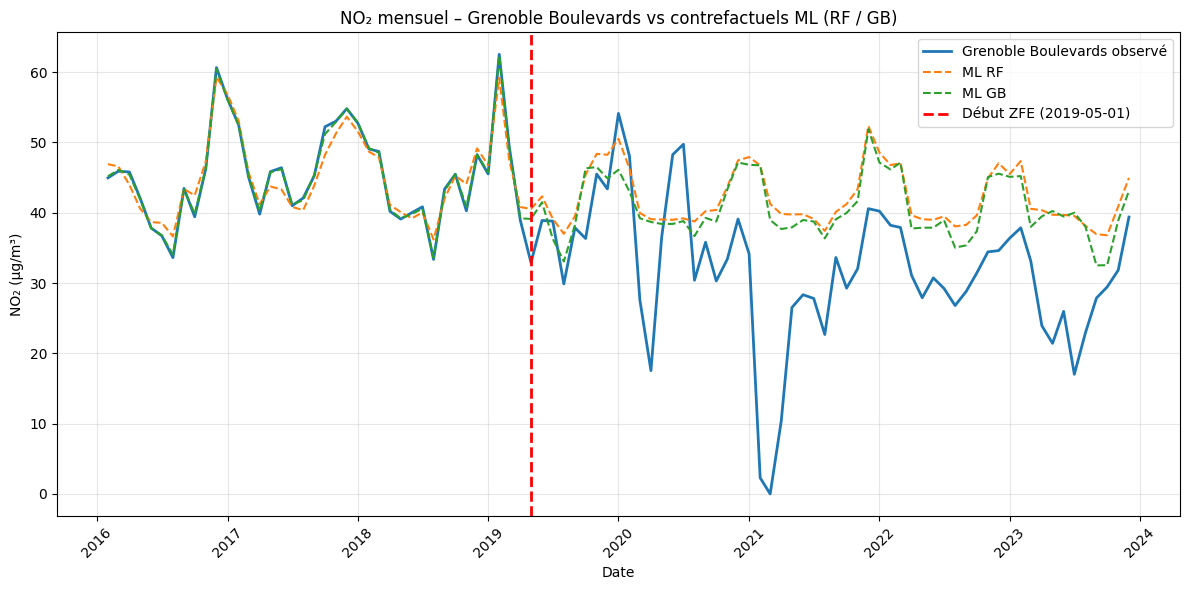

RF – RMSE pré-ZFE : 1.812 | RMSE post-ZFE : 13.651
GB – RMSE pré-ZFE : 0.284 | RMSE post-ZFE : 12.891


In [5]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# =============================
# 0. Chemins & chargement
# =============================
HERE = Path().resolve()      # dossier zfe-scm
ROOT = HERE.parent           # racine du projet
DATA = ROOT / "data"

# Grenoble (Les Frênes + Boulevards)
grenoble_daily = pd.read_csv(DATA / "pollution_grenoble_no2_daily_clean.csv")
grenoble_daily["date"] = pd.to_datetime(grenoble_daily["date"])

# Donneurs
donors_daily = pd.read_csv(DATA / "no2_all_stations_daily_clean.csv")
donors_daily["date"] = pd.to_datetime(donors_daily["date"])

# Meta ZFE pour la date de traitement
zfe_meta = pd.read_csv(DATA / "zfe_meta.csv")
grenoble_row = zfe_meta.loc[zfe_meta["publisher_zfe_id"] == "GRENOBLE"].iloc[0]
zfe_start = pd.to_datetime(grenoble_row["first_date_debut"])
zfe_start_month = zfe_start.to_period("M").to_timestamp()
print("Début ZFE Grenoble :", zfe_start.date())

# Harmoniser les IDs
grenoble_daily["station_id"] = grenoble_daily["station_id"].astype(str).str.strip()
donors_daily["station_id"]   = donors_daily["station_id"].astype(str).str.strip()

print("Stations Grenoble :")
display(grenoble_daily[["station_id", "station_name"]].drop_duplicates())

# =============================
# 1. Station traitée = Les Frênes
#    (change 'frene' en 'boulevard' pour l'autre station)
# =============================
treated_pattern = "boulevard"  

treated_gdf = grenoble_daily[
    grenoble_daily["station_name"].str.contains(treated_pattern, case=False, na=False)
].copy()

if treated_gdf.empty:
    raise ValueError("Impossible de trouver la station traitée avec ce pattern de nom.")

treated_id = treated_gdf["station_id"].iloc[0]
treated_name = treated_gdf["station_name"].iloc[0]
print(f"Station traitée (ML) : {treated_name} ({treated_id})")

# NO2 mensuel station traitée
treated_monthly = (
    treated_gdf
    .set_index("date")["no2_ug_m3"]
    .resample("MS")
    .mean()
)

# =============================
# 2. Panel donneurs mensuel
# =============================
donors_monthly = (
    donors_daily
    .set_index("date")
    .groupby("station_id")["no2_ug_m3"]
    .resample("MS")
    .mean()
    .reset_index()
)

donors_wide = (
    donors_monthly
    .pivot(index="date", columns="station_id", values="no2_ug_m3")
    .sort_index()
)

# =============================
# 3. Construction X / y pour ML
# =============================
# Aligner les dates
panel = donors_wide.copy()
panel["y"] = treated_monthly
panel = panel.dropna(subset=["y"])

# Restreindre la période
start = pd.to_datetime("2016-02-01")
end   = pd.to_datetime("2023-12-01")
panel = panel.loc[(panel.index >= start) & (panel.index <= end)]

# Features de base = NO2 des donneurs
X = panel.drop(columns=["y"]).copy()
# Interpolation des trous côté donneurs
X = X.interpolate(limit_direction="both")
X = X.dropna(axis=1, how="all")  # enlever donneurs complètement vides
donor_ids = X.columns.tolist()

# Ajouter des features de saisonnalité / tendance
dates = panel.index
month = dates.month
t = np.arange(len(dates))  # tendance linéaire

X["month_sin"] = np.sin(2 * np.pi * month / 12)
X["month_cos"] = np.cos(2 * np.pi * month / 12)
X["trend"] = t

y = panel["y"]

print("Shape X :", X.shape, " | nb donneurs :", len(donor_ids))

# Masques pré / post ZFE
pre_mask = dates < zfe_start_month
post_mask = dates >= zfe_start_month

X_pre, y_pre = X[pre_mask], y[pre_mask]
X_all = X

# =============================
# 4. Validation croisée temporelle sur le pré-ZFE
# =============================
tscv = TimeSeriesSplit(n_splits=5)

def eval_model(model, X_pre, y_pre):
    rmses = []
    for train_idx, test_idx in tscv.split(X_pre):
        X_tr, X_te = X_pre.iloc[train_idx], X_pre.iloc[test_idx]
        y_tr, y_te = y_pre.iloc[train_idx], y_pre.iloc[test_idx]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        mse = mean_squared_error(y_te, y_pred)
        rmses.append(mse ** 0.5)
    return np.mean(rmses)

models = {
    "RF": RandomForestRegressor(
        n_estimators=300,
        max_depth=4,
        random_state=0
    ),
    "GB": GradientBoostingRegressor(
        n_estimators=300,
        max_depth=2,
        learning_rate=0.05,
        random_state=0
    ),
}

for name, mdl in models.items():
    rmse_cv = eval_model(mdl, X_pre, y_pre)
    print(f"RMSE CV pré-ZFE ({name}) : {rmse_cv:.3f}")

# =============================
# 5. Entraînement final sur tout le pré-ZFE + prédictions
# =============================
preds_all = {}

for name, mdl in models.items():
    mdl.fit(X_pre, y_pre)
    y_hat = pd.Series(mdl.predict(X_all), index=dates, name=name)
    preds_all[name] = y_hat

# =============================
# 6. Graphique observé vs contrefactuel ML
# =============================
plt.figure(figsize=(12, 6))

plt.plot(dates, y.values, label=f"{treated_name} observé", linewidth=2)

for name, y_hat in preds_all.items():
    plt.plot(dates, y_hat.values, linestyle="--", label=f"ML {name}")

plt.axvline(zfe_start_month, color="red", linestyle="--", linewidth=2,
            label=f"Début ZFE ({zfe_start_month.date()})")

plt.title(f"NO₂ mensuel – {treated_name} vs contrefactuels ML (RF / GB)")
plt.xlabel("Date")
plt.ylabel("NO₂ (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =============================
# 7. Petit résumé des erreurs pré- vs post-ZFE
# =============================
for name, y_hat in preds_all.items():
    mse_pre = mean_squared_error(y[pre_mask], y_hat[pre_mask])
    mse_post = mean_squared_error(y[post_mask], y_hat[post_mask])
    print(f"{name} – RMSE pré-ZFE : {mse_pre**0.5:.3f} | RMSE post-ZFE : {mse_post**0.5:.3f}")


Résumé des ATT (en µg/m³) :


,méthode,ATT_moy_pre,ATT_moy_post,ATT_moy_post_sans_Covid
0,Ridge,1.120388,-1.257020,-1.103198
1,Lasso,0.737667,-1.895919,-1.822457
2,ElasticNet,0.804157,-1.750970,-1.686544


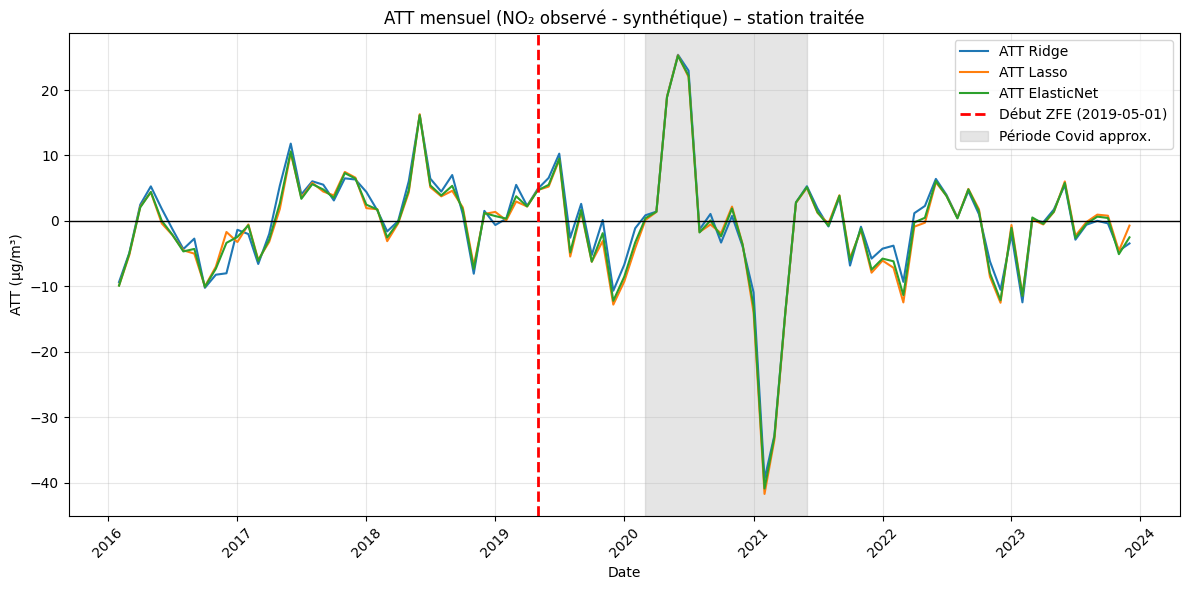

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# =============================
# ATT SCM pour la station traitée courante
# =============================

# 1) construire les séries ATT_t = obs - synth
synth_dict = {
    "Ridge": y_ridge,
    "Lasso": y_lasso,
    "ElasticNet": y_en,
}

att_dict = {}
for name, y_hat in synth_dict.items():
    # on aligne bien les dates
    common_idx = treated_series.index.intersection(y_hat.index)
    att = treated_series.loc[common_idx] - y_hat.loc[common_idx]
    att.name = f"ATT_{name}"
    att_dict[name] = att

# 2) masques temporels
dates = treated_series.index
pre_mask = dates < zfe_start_month
post_mask = dates >= zfe_start_month

# Covid (optionnel, pour moyenne "hors Covid")
covid_start = pd.to_datetime("2020-03-01")
covid_end   = pd.to_datetime("2021-06-01")
covid_mask = (dates >= covid_start) & (dates <= covid_end)
post_nocovid_mask = post_mask & ~covid_mask

# 3) tableau récapitulatif des ATT moyens
rows = []
for name, att in att_dict.items():
    # on re-crée les masques sur l'index d'att
    idx = att.index
    pre = idx < zfe_start_month
    post = idx >= zfe_start_month
    covid = (idx >= covid_start) & (idx <= covid_end)
    post_nocovid = post & ~covid

    rows.append({
        "méthode": name,
        "ATT_moy_pre": att[pre].mean(),
        "ATT_moy_post": att[post].mean(),
        "ATT_moy_post_sans_Covid": att[post_nocovid].mean(),
    })

att_summary = pd.DataFrame(rows)
print("Résumé des ATT (en µg/m³) :")
display(att_summary)

# 4) graphique des ATT dans le temps
plt.figure(figsize=(12, 6))

for name, att in att_dict.items():
    plt.plot(att.index, att.values, label=f"ATT {name}")

plt.axhline(0, color="black", linewidth=1)
plt.axvline(zfe_start_month, color="red", linestyle="--", linewidth=2,
            label=f"Début ZFE ({zfe_start_month.date()})")

# zone Covid en gris (optionnel)
plt.axvspan(covid_start, covid_end, color="grey", alpha=0.2, label="Période Covid approx.")

plt.title("ATT mensuel (NO₂ observé - synthétique) – station traitée")
plt.xlabel("Date")
plt.ylabel("ATT (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
